In [10]:
import numpy as np
import pylab as plt
from collections import Counter
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from pyabc.examples import tuberculosis
import pyabc.prior
from pyabc.plots import plot_marginals, plot_particles
%matplotlib notebook

## Intractable model by Tanaka et al. 2006 for spread of tuberculosis

![](img/transmission_process.png)

### model parameter
$\alpha$: rate with which each infectious host randomly infects other individuals from an unlimited supply of hosts

$\delta$: rate with which a host stops being infectious, either by recovering or dying

$\tau$: rate with which the pathogen of the host mutates randomly within the host, generating a novel haplotype under a single-locus infinite alleles model

$\theta = (\alpha, \delta, \tau)$

$y_{\theta} = (6,3,2,2,1,1,1,1,1,1,1)$: output, vector of clusters, that is different haplotypes. Each number represents the infectious hosts for this particular haplotype

### Observation
$\alpha = 0.2, \delta = 0, \tau = 0.198, m = 20$

assume, that $\delta, \tau$ are known and apply uniform prior

In [11]:
alpha = 0.2
delta = 0.1
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.1, 1, name="alpha")
prior_delta = pyabc.Prior("uniform", 0, 0.1, name="delta")
prior_tau = pyabc.Prior("uniform", 0.01, 1, name="tau")

simulator = tuberculosis.simulator

In [12]:
min(prior_alpha.sample(10000))

0.10001353725609877

In [13]:
for i in range(100):
    params = [prior_alpha.sample(),prior_delta.sample(),prior_tau.sample()]
    y0 = simulator(*params)

y0

array([2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [14]:
list_of_sum = tuberculosis.summaries
for f in list_of_sum:
    print(f(y0))

17
2
3


In [15]:
rej = pyabc.RejectionSampler(priors=[prior_alpha, prior_delta, prior_tau], simulator=simulator, 
                             summaries=tuberculosis.summaries,
                             observation=y0)

In [16]:
rej.sample(nr_samples=1000, threshold=0.01)

Rejection sampler started with threshold: 0.01 and number of samples: 1000
Samples:   1000 - Threshold: 0.01 - Iterations:      46000 - Acceptance rate: 0.021739 - Time:    25.63 s


In [17]:
smc = pyabc.SMCSampler(priors=[prior_alpha, prior_delta, prior_tau], simulator=simulator, 
                             summaries=tuberculosis.summaries,
                             observation=y0)

In [18]:
smc.sample(nr_samples=1000, thresholds=[0.5,0.1,0.05,0.01])

SMC sampler started with thresholds: [0.5, 0.1, 0.05, 0.01] and number of samples: 1000
Rejection sampler started with threshold: 0.5 and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
Samples:   1000 - Thresholds: 0.01 - Iterations:      50041 - Acceptance rate: 0.019984 - Time:    68.36 s


<IPython.core.display.Javascript object>


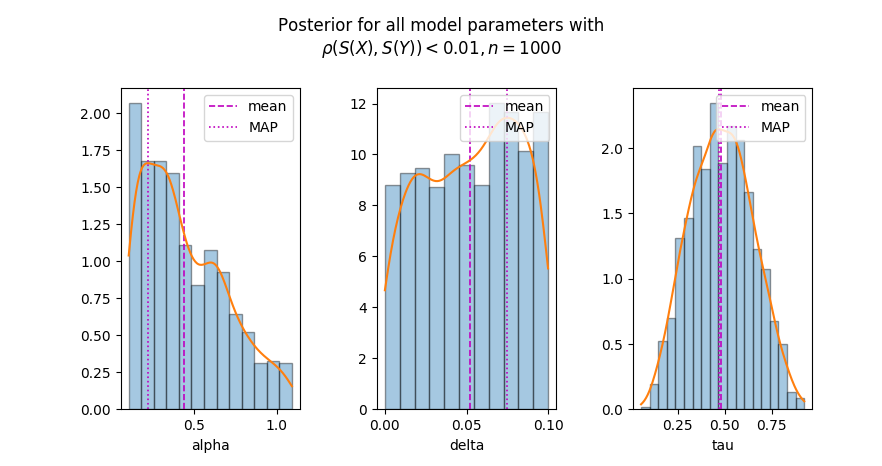

<IPython.core.display.Javascript object>


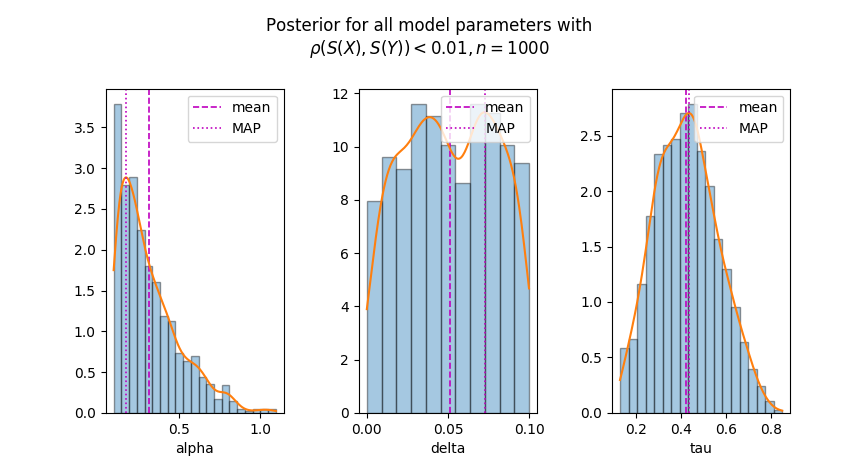

In [20]:
plot_marginals(rej, kde=True, normed=True)
plot_marginals(smc, kde=True, normed=True)

In [21]:
plot_particles(smc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>